# 6.1 Классификация.Соискатели

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Отправьте результат нам

### Полезная литература

- [ODS - классификация](https://habrahabr.ru/company/ods/blog/322534/)
- [Коллаборативная фильтрация - рекомендательная система](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BB%D0%BB%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%B0%D1%8F_%D1%84%D0%B8%D0%BB%D1%8C%D1%82%D1%80%D0%B0%D1%86%D0%B8%D1%8F)
- [Метрики расстояний - косинусная, минковского, проклятье размерности ](http://www.machinelearning.ru/wiki/images/9/9a/Sem1_knn.pdf)
- [Offtop: метрики качества рекомендательных систем](https://habrahabr.ru/company/dca/blog/281066/)

## kNN - ближайшие соседи (15 баллов)

Рассмотрим задачу из соревнования [Amazon Employee Access Challenge](https://www.kaggle.com/c/amazon-employee-access-challenge).

В данной задаче предлагается предсказать, будет ли одобрен запрос сотрудника на получение доступа к тому или иному ресурсу. Все признаки являются категориальными.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import scale

In [2]:
df = pd.read_csv('/home/rimsky/Projects/ml-solutions/ml_course/data/amazon.csv.gz')
df.head()
# ACTION - это целевой признак

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


Обратим внимание, что выборка не сбалансированная. В качестве метрики качества будем использовать [f1-score](https://en.wikipedia.org/wiki/F1_score). 
$$F_1 = 2 \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}}$$

$$precision = \frac{TP}{TP+FP}$$

$$recall = \frac{TP}{TP+FN}$$

0.9421099209618847


/home/rimsky/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


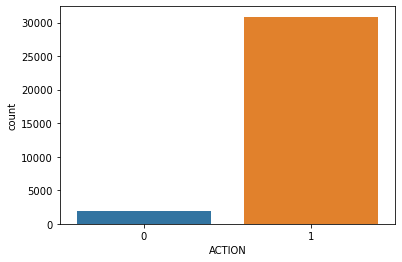

In [3]:
print(df['ACTION'].mean())
sns.countplot('ACTION', data=df)

In [4]:
# число значений у признаков
for col_name in df.columns:
    print(col_name, len(df[col_name].unique()))

ACTION 2
RESOURCE 7518
MGR_ID 4243
ROLE_ROLLUP_1 128
ROLE_ROLLUP_2 177
ROLE_DEPTNAME 449
ROLE_TITLE 343
ROLE_FAMILY_DESC 2358
ROLE_FAMILY 67
ROLE_CODE 343


In [5]:
X = df.drop(['ACTION'], axis=1)
y = df['ACTION']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.8)

# Baseline (4 балла)

Сразу проверим как ведет себя kNN на неподготовленных данных и без тюнинга. Зафиксируйте `n_neighbors=5`, `p=2`. 

- создайте экземпляр `KNeighborsClassifier` с указанными параметрами, обучите его методом `fit` и предскажите значения `predict` для треничровчных данных `X_test`.
- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Обратите внимание на confusion matrix. Какой вывод вы можете сделать из неё? Вспомните лекцию и значение ошибок 1 и 2 рода.

In [6]:
clf = KNeighborsClassifier(n_neighbors=5, p=2)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.22      0.03      0.05      1534
           1       0.94      0.99      0.97     24682

    accuracy                           0.94     26216
   macro avg       0.58      0.51      0.51     26216
weighted avg       0.90      0.94      0.91     26216



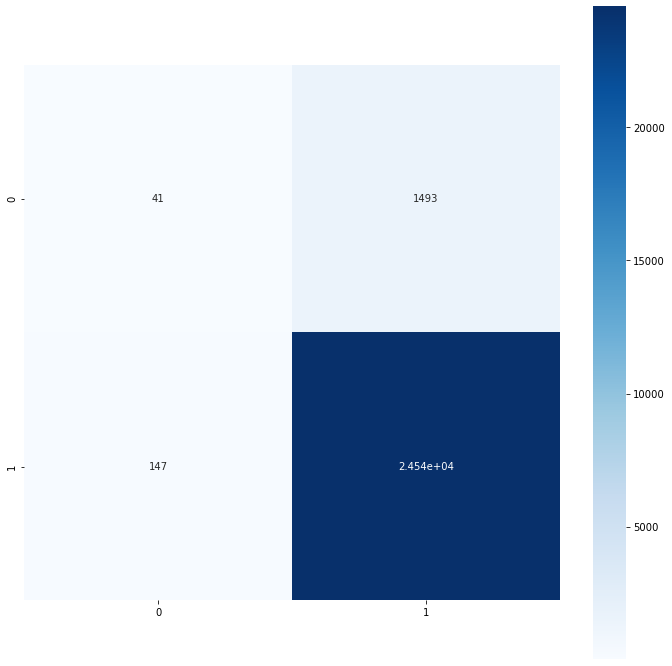

In [7]:
plt.figure(figsize=(12,12)) 
_ = sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.4g')

При фиксированном `n_neighbors=10` проверьте значение метрики на кроссвалидации на 5-фолдах для разных значений `p` из `(1,2,4,6)`. При каком значение `p` метрика достигает максимума?

При кроссвалидации у вас будет получаться N разных значений метрики. Выводите среднее значение и стандартное отклонение.

In [8]:
from sklearn.model_selection import StratifiedKFold 

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i in list([1, 2, 4, 6]):
    clf = KNeighborsClassifier(n_neighbors=10, p=i)
    scores = cross_val_score(clf, X, y, cv=5)
    print("p={} ".format(i))
    print("Mean: {} ".format(scores.mean()))
    print("Std: {} ".format(np.std(scores)))

p=1 
Mean: 0.9403399412531728 
Std: 0.0011825846627015254 
p=2 
Mean: 0.9397906537157343 
Std: 0.0007817359501145312 
p=4 
Mean: 0.9400652811858109 
Std: 0.0009636266775850819 
p=6 
Mean: 0.9400347561567075 
Std: 0.0008814171441785031 


# Счетчики (6 баллов)

Очевидно, что предсказывать лейбл объекта, используя при этом метрический алгоритм на категориальных признаках - это ОЧЕНЬ странная затея. Не удивительно что качество ужасное. Необходимо каким-то образом заменить категориальные признаки вещественными:

- OneHotEncoding - это когда для каждого признака создают другие N бинарных признаков, где N - это количество категорий у категориального признака.
- Счетчики - об это написано в статье http://blogs.technet.com/b/machinelearning/archive/2015/02/17/big-learning-made-easy-with-counts.aspx.

Мы реализуем алгоритм Счетчиков. Его нет в sklearn, поэтому придется реализовать самому. 

Для каждого категориального признака создайте 3 других признака:
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
2. Число `successes` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
3. Сглаженное отношение двух предыдущих величин: (`successes` + 1) / (`counts` + 2).

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `successes` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанные по всей обучающей выборке. Реализуйте и такой вариант. Можно использовать $n = 3$.

Обучение надо проводить только по новым признакам. Изначальные мы не используем.

Счетчики нужно считать по `train`, а в `test` использовать эти же счетчики, иначе счетчики будут содержать информацию о всем датасете что приведет к переобучение!

Подсказка - вам нужно для каждой колонки посчитать 2 аггрегации - сумму и количество. Для замены конкретного значения посчитанным используйте функцию apply над датафреймом. Простое решение займет около 10 строк кода.

![](http://images6.fanpop.com/image/photos/38600000/taiga-iamyourenemy-38620719-282-160.gif)

In [9]:
data = pd.DataFrame(index=df.index)
print(df.shape)
for col_name in df.columns:
    if col_name == 'ACTION':
        continue
    data[col_name + ' counts'] = df[col_name].map(df.groupby(col_name).size())
    data[col_name + ' successes'] = df[col_name].map(df[df['ACTION'] == 1].groupby(col_name).size())
    data[col_name + ' s/c'] = (data[col_name + ' successes'] + 1) / (data[col_name + ' counts'] + 2)

data = data.fillna(0)
data

(32769, 10)


,RESOURCE counts,RESOURCE successes,RESOURCE s/c,MGR_ID counts,MGR_ID successes,MGR_ID s/c,ROLE_ROLLUP_1 counts,ROLE_ROLLUP_1 successes,ROLE_ROLLUP_1 s/c,ROLE_ROLLUP_2 counts,...,ROLE_TITLE s/c,ROLE_FAMILY_DESC counts,ROLE_FAMILY_DESC successes,ROLE_FAMILY_DESC s/c,ROLE_FAMILY counts,ROLE_FAMILY successes,ROLE_FAMILY s/c,ROLE_CODE counts,ROLE_CODE successes,ROLE_CODE s/c
0,3,3.0,0.800000,55,55.0,0.982456,21407,20320.0,0.949180,4424,...,0.967364,6896,6437.0,0.933314,10980,10347,0.942269,3583,3467.0,0.967364
1,30,29.0,0.937500,10,10.0,0.916667,21407,20320.0,0.949180,3945,...,0.951807,12,12.0,0.928571,1287,1220,0.947246,81,78.0,0.951807
2,2,2.0,0.750000,3,3.0,0.800000,184,169.0,0.913978,184,...,0.888712,33,31.0,0.914286,2636,2393,0.907506,1256,1117.0,0.888712
3,1,1.0,0.666667,62,62.0,0.984375,21407,20320.0,0.949180,3945,...,0.920232,1244,1189.0,0.955056,10980,10347,0.942269,4649,4279.0,0.920232
4,8,8.0,0.900000,9,9.0,0.909091,276,257.0,0.928058,138,...,0.857143,19,18.0,0.904762,362,303,0.835165,75,65.0,0.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32764,51,46.0,0.886792,29,28.0,0.935484,21407,20320.0,0.949180,4424,...,0.920232,1244,1189.0,0.955056,10980,10347,0.942269,4649,4279.0,0.920232
32765,2,2.0,0.750000,9,9.0,0.909091,721,695.0,0.962656,721,...,0.961538,5,5.0,0.857143,224,219,0.973451,24,24.0,0.961538
32766,161,155.0,0.957055,5,5.0,0.857143,21407,20320.0,0.949180,2641,...,0.800000,2,2.0,0.750000,78,76,0.962500,3,3.0,0.800000
32767,7,7.0,0.888889,16,11.0,0.666667,275,202.0,0.732852,257,...,0.911616,244,210.0,0.857724,1318,1137,0.862121,394,360.0,0.911616


In [115]:
#Folding 

def folding(df, n):
    folds = []
    part_size = len(df) // n
    for i in range(n):
        folds.append(df[i*part_size:i*part_size+part_size][:])
    return folds


In [116]:
folds = folding(df, 3)

new_data = pd.DataFrame(index=df.index)
for i in range(len(folds)):
    for j in range(len(folds)):
        if i == j:
            continue
        
        for col_name in folds[i].columns:
            if col_name == 'ACTION':
                continue
            new_data.loc[folds[i].index, col_name + ' counts'] = (folds[i][col_name].map(folds[j].groupby(col_name).size()))
            new_data.loc[folds[i].index, col_name + ' successes'] = (folds[i][col_name].map(folds[j][folds[j]['ACTION'] == 1].groupby(col_name).size()))
            new_data.loc[folds[i].index, col_name + ' s/c'] = ((new_data[col_name + ' successes'] + 1) / (new_data[col_name + ' counts'] + 2))

new_data = new_data.fillna(0)
new_data

,RESOURCE counts,RESOURCE successes,RESOURCE s/c,MGR_ID counts,MGR_ID successes,MGR_ID s/c,ROLE_ROLLUP_1 counts,ROLE_ROLLUP_1 successes,ROLE_ROLLUP_1 s/c,ROLE_ROLLUP_2 counts,...,ROLE_TITLE s/c,ROLE_FAMILY_DESC counts,ROLE_FAMILY_DESC successes,ROLE_FAMILY_DESC s/c,ROLE_FAMILY counts,ROLE_FAMILY successes,ROLE_FAMILY s/c,ROLE_CODE counts,ROLE_CODE successes,ROLE_CODE s/c
0,1.0,1.0,0.666667,13.0,13.0,0.933333,7078.0,6712.0,0.948164,1501.0,...,0.966581,2281.0,2118.0,0.928165,3625.0,3401.0,0.937965,1165.0,1127.0,0.966581
1,10.0,9.0,0.833333,3.0,3.0,0.800000,7078.0,6712.0,0.948164,1320.0,...,0.964286,5.0,5.0,0.857143,441.0,415.0,0.939052,26.0,26.0,0.964286
2,1.0,1.0,0.666667,0.0,0.0,0.000000,69.0,66.0,0.943662,69.0,...,0.882222,12.0,11.0,0.857143,943.0,856.0,0.906878,448.0,396.0,0.882222
3,0.0,0.0,0.000000,25.0,25.0,0.962963,7078.0,6712.0,0.948164,1320.0,...,0.912088,402.0,383.0,0.950495,3625.0,3401.0,0.937965,1545.0,1410.0,0.912088
4,2.0,2.0,0.750000,2.0,2.0,0.750000,100.0,96.0,0.950980,54.0,...,0.851852,5.0,4.0,0.714286,113.0,93.0,0.817391,25.0,22.0,0.851852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32764,21.0,18.0,0.826087,10.0,10.0,0.916667,7130.0,6776.0,0.950224,1460.0,...,0.928571,409.0,393.0,0.958637,3674.0,3489.0,0.949402,1552.0,1442.0,0.928571
32765,0.0,0.0,0.000000,3.0,3.0,0.800000,224.0,217.0,0.964602,224.0,...,0.833333,2.0,2.0,0.750000,52.0,51.0,0.962963,4.0,4.0,0.833333
32766,58.0,56.0,0.950000,3.0,3.0,0.800000,7130.0,6776.0,0.950224,884.0,...,0.750000,1.0,1.0,0.666667,22.0,22.0,0.958333,2.0,2.0,0.750000
32767,3.0,3.0,0.800000,7.0,6.0,0.777778,88.0,71.0,0.800000,78.0,...,0.906977,86.0,72.0,0.829545,426.0,373.0,0.873832,127.0,116.0,0.906977


Проверьте какое качество теперь получается на кроссвалидации для новых данных.

In [119]:
#без фолдинга
clf = KNeighborsClassifier()
scores = cross_val_score(clf, data, y, cv=5)
print(scores.mean())

0.9471756291893041


In [120]:
#с фолдингом
clf = KNeighborsClassifier()
scores = cross_val_score(clf, new_data, y, cv=5)
print(scores.mean())

0.9413774429860677


In [121]:
#без фолдинга
train_X, test_X, train_Y, test_Y = train_test_split(data, y, random_state=42, test_size=0.8)
clf.fit(train_X, train_Y)
y_pred = clf.predict(test_X)

print(classification_report(test_Y, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.11      0.17      1534
           1       0.95      0.99      0.97     24682

    accuracy                           0.94     26216
   macro avg       0.71      0.55      0.57     26216
weighted avg       0.92      0.94      0.92     26216



In [122]:
#c фолдингом
train_X, test_X, train_Y, test_Y = train_test_split(new_data, y, random_state=42, test_size=0.8)
clf.fit(train_X, train_Y)
y_pred = clf.predict(test_X)

print(classification_report(test_Y, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.06      0.11      1534
           1       0.94      0.99      0.97     24682

    accuracy                           0.94     26216
   macro avg       0.67      0.53      0.54     26216
weighted avg       0.91      0.94      0.92     26216



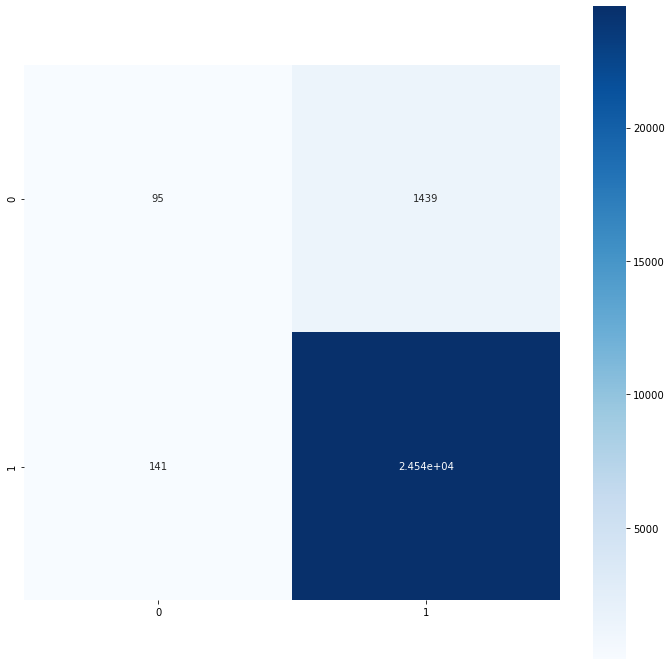

In [123]:
plt.figure(figsize=(12,12)) 
_ = sns.heatmap(confusion_matrix(test_Y, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.4g')

- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Оцените на сколько улучшилось качество.

# Co-co-co-combo (5 баллов)

Добавьте в исходную выборку парные признаки — то есть для каждой пары $(f_i, f_j)$, $i < j$ исходных категориальных признаков добавьте новый категориальный признак $f_{ij}$, значение которого является конкатенацией значений $f_i$ и $f_j$ (желательно через какой-нибудь специальный символ во избежание коллизий). Посчитайте счетчики для этой выборки, найдите качество метода $k$ ближайших соседей с наилучшим $k$ (с фолдингом и без).

In [124]:
df_combo = df.copy()

newdf = pd.DataFrame(index=df_combo.index)
for col_name in df_combo.columns:
    if col_name == 'ACTION':
        continue
    for col in df_combo.columns:
        if col == 'ACTION' or col == col_name:
            continue
        newdf[col_name + '+' + col] = df[col_name].astype(str) + '+' + df[col].astype(str)
    
df_combo = newdf
df_combo['ACTION'] = df['ACTION']
df_combo

,RESOURCE+MGR_ID,RESOURCE+ROLE_ROLLUP_1,RESOURCE+ROLE_ROLLUP_2,RESOURCE+ROLE_DEPTNAME,RESOURCE+ROLE_TITLE,RESOURCE+ROLE_FAMILY_DESC,RESOURCE+ROLE_FAMILY,RESOURCE+ROLE_CODE,MGR_ID+RESOURCE,MGR_ID+ROLE_ROLLUP_1,...,ROLE_FAMILY+ROLE_CODE,ROLE_CODE+RESOURCE,ROLE_CODE+MGR_ID,ROLE_CODE+ROLE_ROLLUP_1,ROLE_CODE+ROLE_ROLLUP_2,ROLE_CODE+ROLE_DEPTNAME,ROLE_CODE+ROLE_TITLE,ROLE_CODE+ROLE_FAMILY_DESC,ROLE_CODE+ROLE_FAMILY,ACTION
0,39353+85475,39353+117961,39353+118300,39353+123472,39353+117905,39353+117906,39353+290919,39353+117908,85475+39353,85475+117961,...,290919+117908,117908+39353,117908+85475,117908+117961,117908+118300,117908+123472,117908+117905,117908+117906,117908+290919,1
1,17183+1540,17183+117961,17183+118343,17183+123125,17183+118536,17183+118536,17183+308574,17183+118539,1540+17183,1540+117961,...,308574+118539,118539+17183,118539+1540,118539+117961,118539+118343,118539+123125,118539+118536,118539+118536,118539+308574,1
2,36724+14457,36724+118219,36724+118220,36724+117884,36724+117879,36724+267952,36724+19721,36724+117880,14457+36724,14457+118219,...,19721+117880,117880+36724,117880+14457,117880+118219,117880+118220,117880+117884,117880+117879,117880+267952,117880+19721,1
3,36135+5396,36135+117961,36135+118343,36135+119993,36135+118321,36135+240983,36135+290919,36135+118322,5396+36135,5396+117961,...,290919+118322,118322+36135,118322+5396,118322+117961,118322+118343,118322+119993,118322+118321,118322+240983,118322+290919,1
4,42680+5905,42680+117929,42680+117930,42680+119569,42680+119323,42680+123932,42680+19793,42680+119325,5905+42680,5905+117929,...,19793+119325,119325+42680,119325+5905,119325+117929,119325+117930,119325+119569,119325+119323,119325+123932,119325+19793,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32764,23497+16971,23497+117961,23497+118300,23497+119993,23497+118321,23497+240983,23497+290919,23497+118322,16971+23497,16971+117961,...,290919+118322,118322+23497,118322+16971,118322+117961,118322+118300,118322+119993,118322+118321,118322+240983,118322+290919,1
32765,25139+311198,25139+91261,25139+118026,25139+122392,25139+121143,25139+173805,25139+249618,25139+121145,311198+25139,311198+91261,...,249618+121145,121145+25139,121145+311198,121145+91261,121145+118026,121145+122392,121145+121143,121145+173805,121145+249618,1
32766,34924+28805,34924+117961,34924+118327,34924+120299,34924+124922,34924+152038,34924+118612,34924+124924,28805+34924,28805+117961,...,118612+124924,124924+34924,124924+28805,124924+117961,124924+118327,124924+120299,124924+124922,124924+152038,124924+118612,1
32767,80574+55643,80574+118256,80574+118257,80574+117945,80574+280788,80574+280788,80574+292795,80574+119082,55643+80574,55643+118256,...,292795+119082,119082+80574,119082+55643,119082+118256,119082+118257,119082+117945,119082+280788,119082+280788,119082+292795,1


In [125]:
data_combo = pd.DataFrame(index=df_combo.index)
for col_name in df_combo.columns:
    if col_name == 'ACTION':
        continue
    data_combo[col_name + ' counts'] = df_combo[col_name].map(df_combo.groupby(col_name).size())
    data_combo[col_name + ' successes'] = df_combo[col_name].map(df_combo[df_combo['ACTION'] == 1].groupby(col_name).size())
    data_combo[col_name + ' s/c'] = (data_combo[col_name + ' successes'] + 1) / (data_combo[col_name + ' counts'] + 2)
    
data_combo = data_combo.fillna(0)
data_combo

,RESOURCE+MGR_ID counts,RESOURCE+MGR_ID successes,RESOURCE+MGR_ID s/c,RESOURCE+ROLE_ROLLUP_1 counts,RESOURCE+ROLE_ROLLUP_1 successes,RESOURCE+ROLE_ROLLUP_1 s/c,RESOURCE+ROLE_ROLLUP_2 counts,RESOURCE+ROLE_ROLLUP_2 successes,RESOURCE+ROLE_ROLLUP_2 s/c,RESOURCE+ROLE_DEPTNAME counts,...,ROLE_CODE+ROLE_DEPTNAME s/c,ROLE_CODE+ROLE_TITLE counts,ROLE_CODE+ROLE_TITLE successes,ROLE_CODE+ROLE_TITLE s/c,ROLE_CODE+ROLE_FAMILY_DESC counts,ROLE_CODE+ROLE_FAMILY_DESC successes,ROLE_CODE+ROLE_FAMILY_DESC s/c,ROLE_CODE+ROLE_FAMILY counts,ROLE_CODE+ROLE_FAMILY successes,ROLE_CODE+ROLE_FAMILY s/c
0,3,3.0,0.800000,3,3.0,0.800000,3,3.0,0.800000,1,...,0.958333,3583,3467.0,0.967364,2607,2528.0,0.969337,3583,3467.0,0.967364
1,1,1.0,0.666667,26,25.0,0.928571,11,10.0,0.846154,1,...,0.857143,81,78.0,0.951807,12,12.0,0.928571,81,78.0,0.951807
2,1,1.0,0.666667,2,2.0,0.750000,2,2.0,0.750000,2,...,0.865591,1256,1117.0,0.888712,2,2.0,0.750000,1256,1117.0,0.888712
3,1,1.0,0.666667,1,1.0,0.666667,1,1.0,0.666667,1,...,0.970588,4649,4279.0,0.920232,531,508.0,0.954972,4649,4279.0,0.920232
4,2,2.0,0.750000,3,3.0,0.800000,2,2.0,0.750000,2,...,0.875000,75,65.0,0.857143,17,16.0,0.894737,75,65.0,0.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32764,1,1.0,0.666667,30,26.0,0.843750,10,8.0,0.750000,1,...,0.970588,4649,4279.0,0.920232,531,508.0,0.954972,4649,4279.0,0.920232
32765,1,1.0,0.666667,1,1.0,0.666667,1,1.0,0.666667,2,...,0.800000,24,24.0,0.961538,3,3.0,0.800000,24,24.0,0.961538
32766,1,1.0,0.666667,138,134.0,0.964286,90,90.0,0.989130,9,...,0.800000,3,3.0,0.800000,2,2.0,0.750000,3,3.0,0.800000
32767,1,1.0,0.666667,1,1.0,0.666667,1,1.0,0.666667,2,...,0.947368,394,360.0,0.911616,223,199.0,0.888889,394,360.0,0.911616


In [132]:
folds = folding(df_combo, 3)

new_data_combo = pd.DataFrame(index=df_combo.index)
for i in range(len(folds)):
    for j in range(len(folds)):
        if i == j:
            continue
        
        for col_name in folds[i].columns:
            if col_name == 'ACTION':
                continue
            new_data_combo.loc[folds[i].index, col_name + ' counts'] = (folds[i][col_name].map(folds[j].groupby(col_name).size()))
            new_data_combo.loc[folds[i].index, col_name + ' successes'] = (folds[i][col_name].map(folds[j][folds[j]['ACTION'] == 1].groupby(col_name).size()))
            new_data_combo.loc[folds[i].index, col_name + ' s/c'] = ((new_data_combo[col_name + ' successes'] + 1) / (new_data_combo[col_name + ' counts'] + 2))

new_data_combo = new_data_combo.fillna(0)
new_data_combo

,RESOURCE+MGR_ID counts,RESOURCE+MGR_ID successes,RESOURCE+MGR_ID s/c,RESOURCE+ROLE_ROLLUP_1 counts,RESOURCE+ROLE_ROLLUP_1 successes,RESOURCE+ROLE_ROLLUP_1 s/c,RESOURCE+ROLE_ROLLUP_2 counts,RESOURCE+ROLE_ROLLUP_2 successes,RESOURCE+ROLE_ROLLUP_2 s/c,RESOURCE+ROLE_DEPTNAME counts,...,ROLE_CODE+ROLE_DEPTNAME s/c,ROLE_CODE+ROLE_TITLE counts,ROLE_CODE+ROLE_TITLE successes,ROLE_CODE+ROLE_TITLE s/c,ROLE_CODE+ROLE_FAMILY_DESC counts,ROLE_CODE+ROLE_FAMILY_DESC successes,ROLE_CODE+ROLE_FAMILY_DESC s/c,ROLE_CODE+ROLE_FAMILY counts,ROLE_CODE+ROLE_FAMILY successes,ROLE_CODE+ROLE_FAMILY s/c
0,1.0,1.0,0.666667,1.0,1.0,0.666667,1.0,1.0,0.666667,0.0,...,0.833333,1165.0,1127.0,0.966581,846.0,821.0,0.969340,1165.0,1127.0,0.966581
1,0.0,0.0,0.000000,7.0,6.0,0.777778,4.0,3.0,0.666667,0.0,...,0.000000,26.0,26.0,0.964286,5.0,5.0,0.857143,26.0,26.0,0.964286
2,0.0,0.0,0.000000,1.0,1.0,0.666667,1.0,1.0,0.666667,1.0,...,0.833333,448.0,396.0,0.882222,0.0,0.0,0.000000,448.0,396.0,0.882222
3,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.941176,1545.0,1410.0,0.912088,173.0,165.0,0.948571,1545.0,1410.0,0.912088
4,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.750000,25.0,22.0,0.851852,5.0,4.0,0.714286,25.0,22.0,0.851852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32764,0.0,0.0,0.000000,12.0,10.0,0.785714,2.0,1.0,0.500000,0.0,...,0.951220,1552.0,1442.0,0.928571,167.0,162.0,0.964497,1552.0,1442.0,0.928571
32765,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,4.0,4.0,0.833333,0.0,0.0,0.000000,4.0,4.0,0.833333
32766,0.0,0.0,0.000000,49.0,47.0,0.941176,32.0,32.0,0.970588,3.0,...,0.750000,2.0,2.0,0.750000,1.0,1.0,0.666667,2.0,2.0,0.750000
32767,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.945205,127.0,116.0,0.906977,78.0,68.0,0.862500,127.0,116.0,0.906977


In [134]:
#удаляем стлбец, где много нулей
new_data_combo = new_data_combo.drop(columns = ['RESOURCE+MGR_ID counts', 'RESOURCE+MGR_ID successes', 'RESOURCE+MGR_ID s/c'])

In [135]:
#c фолдингом
clf = KNeighborsClassifier(n_neighbors=3, p=2)
scores = cross_val_score(clf, new_data_combo, y, cv=5)
print(scores.mean())

0.9414993894295666


In [136]:
#без фолдинга
clf = KNeighborsClassifier(n_neighbors=3, p=2)
scores = cross_val_score(clf, data_combo, y, cv=5)
print(scores.mean())

0.9524550389139403


In [99]:
from sklearn.model_selection import GridSearchCV

params = {
    "n_neighbors": np.arange(2, 10), 
    "p": [2,4]
}

search = GridSearchCV(KNeighborsClassifier(), params, n_jobs=2, 
                      cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), verbose=2)
%time search.fit(data_combo, y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  3.8min
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed:  9.7min finished


CPU times: user 1.6 s, sys: 179 ms, total: 1.78 s
Wall time: 9min 41s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=2,
             param_grid={'n_neighbors': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'p': [2, 4]},
             verbose=2)

BEST: score=0.9516922298456925, params={'n_neighbors': 3, 'p': 2}


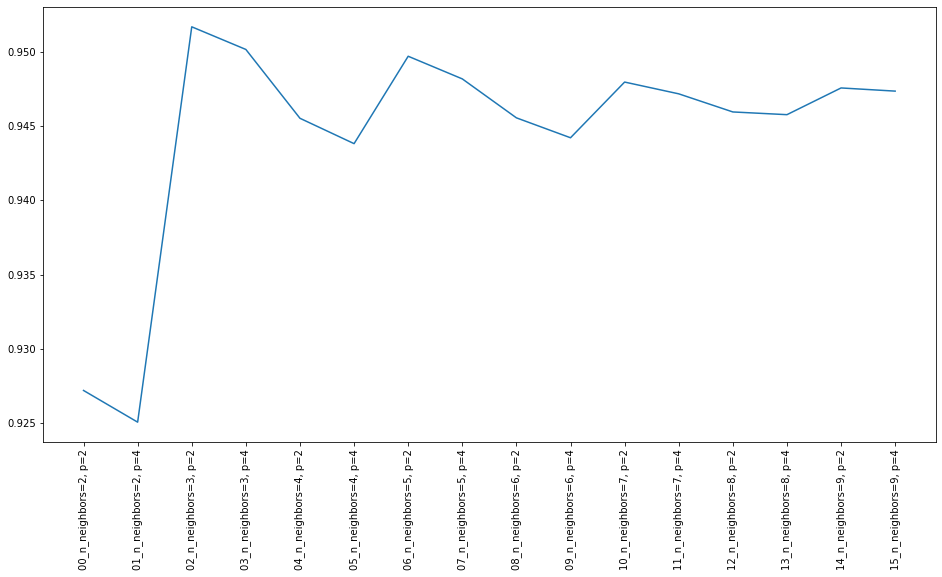

In [100]:
x_ticks = ["{:02d}_n_neighbors={}, p={}".format(i, p['n_neighbors'], p['p']) for i,p in enumerate(search.cv_results_['params'])]

plt.figure(figsize=(16,8))
plt.plot(x_ticks, search.cv_results_['mean_test_score'])
_ =plt.xticks(rotation=90)

print("BEST: score={}, params={}".format(search.best_score_, search.best_params_))

In [138]:
#без фолднига
train_X, test_X, train_Y, test_Y = train_test_split(data_combo, y, random_state=42, test_size=0.8)
clf.fit(train_X, train_Y)
y_pred = clf.predict(test_X)

print(classification_report(test_Y, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.20      0.28      1534
           1       0.95      0.98      0.97     24682

    accuracy                           0.94     26216
   macro avg       0.70      0.59      0.63     26216
weighted avg       0.92      0.94      0.93     26216



In [137]:
#с фолдингом
train_X, test_X, train_Y, test_Y = train_test_split(new_data_combo, y, random_state=42, test_size=0.8)
clf.fit(train_X, train_Y)
y_pred = clf.predict(test_X)

print(classification_report(test_Y, y_pred))

              precision    recall  f1-score   support

           0       0.37      0.17      0.23      1534
           1       0.95      0.98      0.97     24682

    accuracy                           0.93     26216
   macro avg       0.66      0.57      0.60     26216
weighted avg       0.92      0.93      0.92     26216



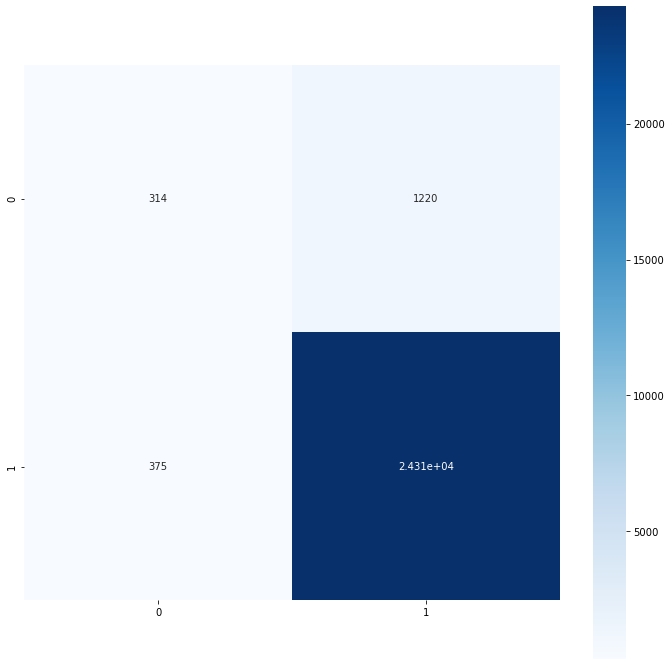

In [139]:
plt.figure(figsize=(12,12)) 
_ = sns.heatmap(confusion_matrix(test_Y, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.4g')

- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Оцените на сколько улучшилось качество. Не похоже ли это на переобусение?

Внимание! Обучение на этом этапе может быть долгим. На i5 16GB кроссвалидация на 5 фолдах заняла 30 минут!

# Target encoding
Допустим, у нас есть категоральный признак х и целевой у; нужно сгруппировать значения признака х по значениям признака у и посчитать среднее. Затем все значения из х заменяем на среднее по соответствующему у.


Подробнее написано в статье: https://maxhalford.github.io/blog/target-encoding/


In [85]:
df_target = df.copy()

In [98]:
data_target = pd.DataFrame(index=df_target.index)
for col_name in df_target.columns:
    if col_name == 'ACTION':
        continue
    means = df.groupby(col_name)['ACTION'].mean()
    data_target[col_name] = df[col_name].map(means)

data_target

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1.000000,1.000000,0.949222,0.956148,0.958333,0.967625,0.933440,0.942350,0.967625
1,0.966667,1.000000,0.949222,0.969075,0.893082,0.962963,1.000000,0.947941,0.962963
2,1.000000,1.000000,0.918478,0.918478,0.923077,0.889331,0.939394,0.907815,0.889331
3,1.000000,1.000000,0.949222,0.969075,0.989474,0.920413,0.955788,0.942350,0.920413
4,1.000000,1.000000,0.931159,0.876812,0.755556,0.866667,0.947368,0.837017,0.866667
...,...,...,...,...,...,...,...,...,...
32764,0.901961,0.965517,0.949222,0.956148,0.989474,0.920413,0.955788,0.942350,0.920413
32765,1.000000,1.000000,0.963939,0.963939,1.000000,1.000000,1.000000,0.977679,1.000000
32766,0.962733,1.000000,0.949222,0.954563,1.000000,1.000000,1.000000,0.974359,1.000000
32767,1.000000,0.687500,0.734545,0.719844,0.864947,0.913706,0.860656,0.862671,0.913706


In [107]:
from sklearn.model_selection import GridSearchCV

params = {
    "n_neighbors": np.arange(2, 10), 
    "p": [2,4]
}

search = GridSearchCV(KNeighborsClassifier(), params, n_jobs=2, 
                      cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), verbose=2)
%time search.fit(data_target, y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   22.4s
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed:   56.7s finished


CPU times: user 704 ms, sys: 69.2 ms, total: 773 ms
Wall time: 56.9 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=2,
             param_grid={'n_neighbors': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'p': [2, 4]},
             verbose=2)

BEST: score=0.9700021109070468, params={'n_neighbors': 9, 'p': 2}


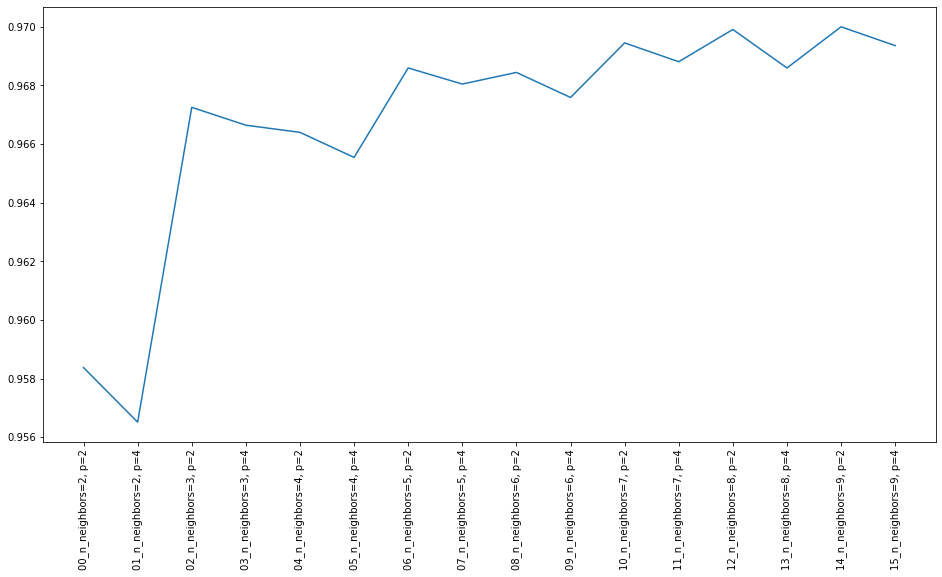

In [108]:
x_ticks = ["{:02d}_n_neighbors={}, p={}".format(i, p['n_neighbors'], p['p']) for i,p in enumerate(search.cv_results_['params'])]

plt.figure(figsize=(16,8))
plt.plot(x_ticks, search.cv_results_['mean_test_score'])
_ =plt.xticks(rotation=90)

print("BEST: score={}, params={}".format(search.best_score_, search.best_params_))

In [115]:
clf = KNeighborsClassifier(n_neighbors=9, p=2)
scores = cross_val_score(clf, data_target, y, cv=5)
print(scores.mean())

0.9717721295168369


In [116]:
train_X, test_X, train_Y, test_Y = train_test_split(data_target, y, random_state=42, test_size=0.8)
clf.fit(train_X, train_Y)
y_pred = clf.predict(test_X)

print(classification_report(test_Y, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.61      0.69      1534
           1       0.98      0.99      0.98     24682

    accuracy                           0.97     26216
   macro avg       0.89      0.80      0.84     26216
weighted avg       0.97      0.97      0.97     26216



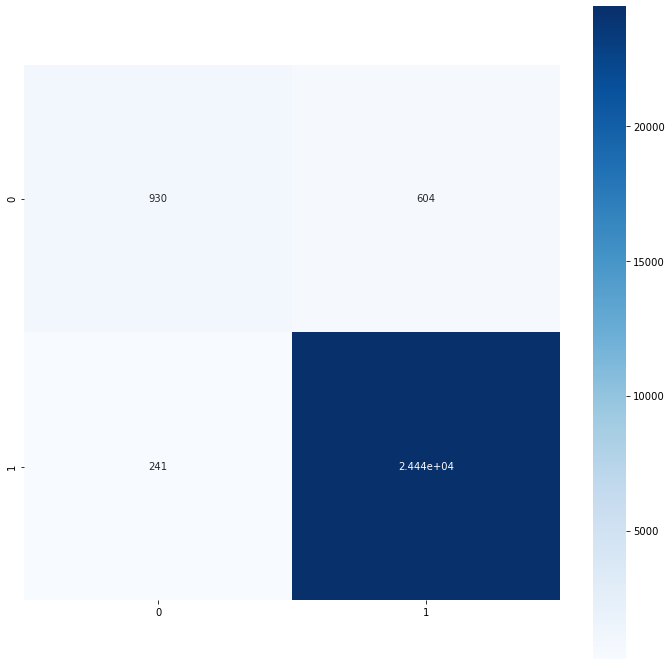

In [117]:
plt.figure(figsize=(12,12)) 
_ = sns.heatmap(confusion_matrix(test_Y, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.4g')

Сравните результаты. 

Какой недостаток есть у target encoding?

